# Modelo predictivo  (Espacial) de siniestros en las calles de Santiago
- UDD - MDS18 - BDA
- Final Delivery 
- 10_Final_Geo_Project_Grid_Creation-Static_Features
- 09 August 2019

**CHANGE KERNEL:** geo_p_3_7

## Datasets (Landing)

###  CONASET
http://mapas-conaset.opendata.arcgis.com/search?groupIds=fca1f61c6556499db843c09cc80c70c0

Estas capas contienen la geocodificación de los accidentes de tránsito registrados en la Región Metropolitana entre los años 2013 y 2018. Contiene los detalles de fecha (en la mayoria solo día/mes), tipo de accidente, causa basal del accidente, dirección donde ocurrió el accidente, fallecidos y lesionados según gravedad. 
- [Siniestros RM - 2013](http://mapas-conaset.opendata.arcgis.com/datasets/12cb58c27a2846dfa60cf629a14d611a_0)
- [Siniestros RM - 2014](http://mapas-conaset.opendata.arcgis.com/datasets/aa5b5322bc564b809aa29c70658b9cf9_0)
- [Siniestros RM - 2015](http://mapas-conaset.opendata.arcgis.com/datasets/dafa26dbce99467985596d8a58216b79_0)
- [Siniestros RM - 2016](http://mapas-conaset.opendata.arcgis.com/datasets/32ee49c703b840b885b9c80b37ae72d0_0)
- [Siniestros RM - 2017](http://mapas-conaset.opendata.arcgis.com/datasets/907addac92b74e3fa30d40edb72d1813_0)
- [Siniestros RM - 2018](http://mapas-conaset.opendata.arcgis.com/datasets/3a084373b58b45d0ae01d9c14a231cf8_0)

`Year Columns order are different. Need to be corrected before be concatenated` 

### OpenStreetMap
- POI and streets of Santiago
<br><br>
http://download.geofabrik.de/south-america/chile.html

## Main Libraries

In [1]:
from math import radians, cos, sin, asin, sqrt, atan2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
import seaborn as sns
import folium
import networkx as nx
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString, MultiLineString
import shapefile as shp
import gpd_lite_toolbox as glt
from gpd_lite_toolbox.utils_carto import m_plot_dataframe, m_plot_multipolygon
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(context='paper', style='ticks', palette='inferno')
sns.mpl.rc("figure", figsize=(10, 6))
mpl.rcParams['figure.dpi']= 150

## Main Functions

In [3]:
def intersection(municipality, urban_area):
    return municipality.intersection(urban_area)

In [4]:
def urban_part(municipality):
    return intersection(municipality, stgo)

## Getting Raw Data

### Restrict Analysis inside Santiago Municipality Area

In [5]:
urban_areas = gpd.read_file('../data/OSM_Chile/urban_areas/',
                            crs={'init': 'epsg:5361'})
municipalities = gpd.read_file(
    '../data/OSM_Chile/shapefile_comunas/division_comunal.shp',
    crs={'init': 'epsg:5361'})
stgo_municipalities = gpd.sjoin(municipalities,
                                urban_areas[urban_areas.NOMBRE == 'Santiago'],
                                op='intersects')
stgo = urban_areas[urban_areas.NOMBRE == 'Santiago'].geometry.values[0]
stgo_shape = urban_areas[urban_areas.NOMBRE == 'Santiago'].to_crs(
    {'init': 'epsg:4326'})

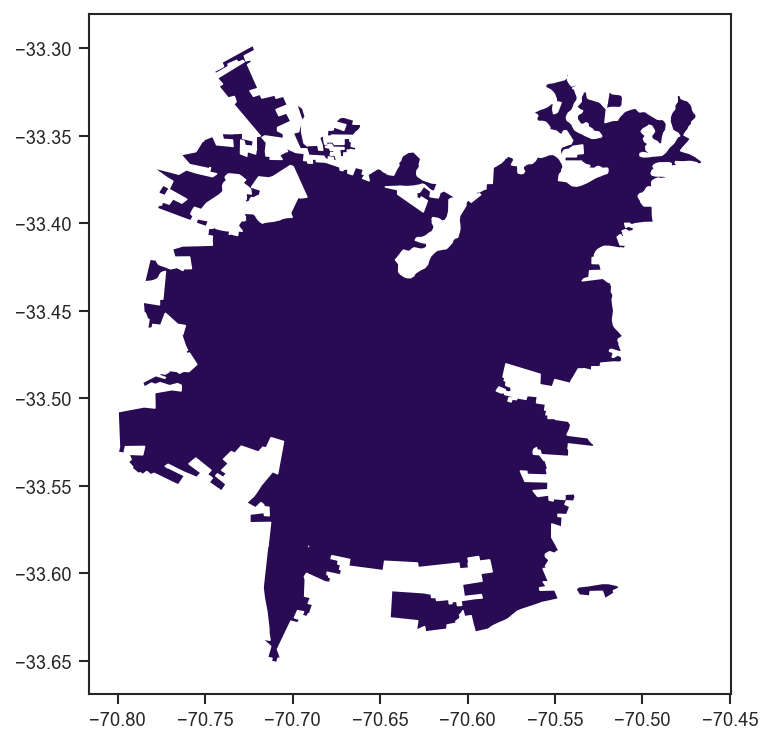

In [6]:
stgo_shape.plot()

In [7]:
# Comuna of Santiago used for test only 
com_stgo = municipalities[municipalities.NOM_COM == 'Santiago'].to_crs(
    {'init': 'epsg:4326'})

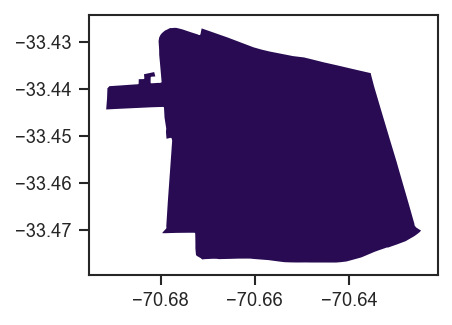

In [8]:
com_stgo.plot(figsize=(3, 3))

### Getting POIs

In [9]:
ls ../data/OSM_Chile/chile-latest-free/ 

README                          gis_osm_pois_free_1.cpg
gis_osm_buildings_a_free_1.cpg  gis_osm_pois_free_1.dbf
gis_osm_buildings_a_free_1.dbf  gis_osm_pois_free_1.prj
gis_osm_buildings_a_free_1.prj  gis_osm_pois_free_1.shp
gis_osm_buildings_a_free_1.shp  gis_osm_pois_free_1.shx
gis_osm_buildings_a_free_1.shx  gis_osm_railways_free_1.cpg
gis_osm_landuse_a_free_1.cpg    gis_osm_railways_free_1.dbf
gis_osm_landuse_a_free_1.dbf    gis_osm_railways_free_1.prj
gis_osm_landuse_a_free_1.prj    gis_osm_railways_free_1.shp
gis_osm_landuse_a_free_1.shp    gis_osm_railways_free_1.shx
gis_osm_landuse_a_free_1.shx    gis_osm_roads_free_1.cpg
gis_osm_natural_a_free_1.cpg    gis_osm_roads_free_1.dbf
gis_osm_natural_a_free_1.dbf    gis_osm_roads_free_1.prj
gis_osm_natural_a_free_1.prj    gis_osm_roads_free_1.shp
gis_osm_natural_a_free_1.shp    gis_osm_roads_free_1.shx
gis_osm_natural_a_free_1.shx    gis_osm_traffic_a_free_1.cpg
gis_osm_natural_free_1.cpg      gis_osm_traffic_a_free_1.dbf
gis_osm_natur

`There are a shapefile (gis_osm_pois_free_1) with only one point per POI. WE should convert to a pandas df:`

In [10]:
pois_path = "../data/OSM_Chile/chile-latest-free/gis_osm_pois_free_1.shp"

In [11]:
pois = gpd.read_file(pois_path, encoding='utf-8', crs={'init': 'epsg:5361'})
pois.shape

(58338, 5)

In [12]:
pois.head()

osm_id  code         fclass                         name  \
0     386313  2519       optician                Lentes Online   
1  102660236  2742      viewpoint       Mirador Castillo Wolff   
2  133663460  2304            pub                Bar Ciudadano   
3  133769438  2007        library  Café Literario Santa Isabel   
4  214182518  2251  sports_centre             Parque Sausalito   

                          geometry  
0  POINT (-70.6511137 -33.4395505)  
1  POINT (-71.5649832 -33.0194413)  
2   POINT (-70.628488 -33.4462244)  
3  POINT (-70.6146478 -33.4465384)  
4  POINT (-71.5370463 -33.0146331)

In [13]:
pois = gpd.sjoin(pois, stgo_shape, op='intersects')

In [14]:
pois.head()

osm_id  code    fclass                         name  \
0     386313  2519  optician                Lentes Online   
2  133663460  2304       pub                Bar Ciudadano   
3  133769438  2007   library  Café Literario Santa Isabel   
7  223920407  2722    museum       Museo de los Tajamares   
8  240434655  2101  pharmacy            Farmacias Ahumada   

                          geometry  index_right    NOMBRE TIPO_AREA  \
0  POINT (-70.6511137 -33.4395505)          385  Santiago    Ciudad   
2   POINT (-70.628488 -33.4462244)          385  Santiago    Ciudad   
3  POINT (-70.6146478 -33.4465384)          385  Santiago    Ciudad   
7  POINT (-70.6303997 -33.4355959)          385  Santiago    Ciudad   
8   POINT (-70.5250533 -33.376238)          385  Santiago    Ciudad   

      SHAPE_Leng    SHAPE_Area  
0  427491.444262  5.821041e+08  
2  427491.444262  5.821041e+08  
3  427491.444262  5.821041e+08  
7  427491.444262  5.821041e+08  
8  427491.444262  5.821041e+08

In [15]:
del pois['index_right']
del pois['NOMBRE']
del pois['TIPO_AREA']
del pois['SHAPE_Leng']
del pois['SHAPE_Area']

pois.crs = {'init' :'epsg:4326'}

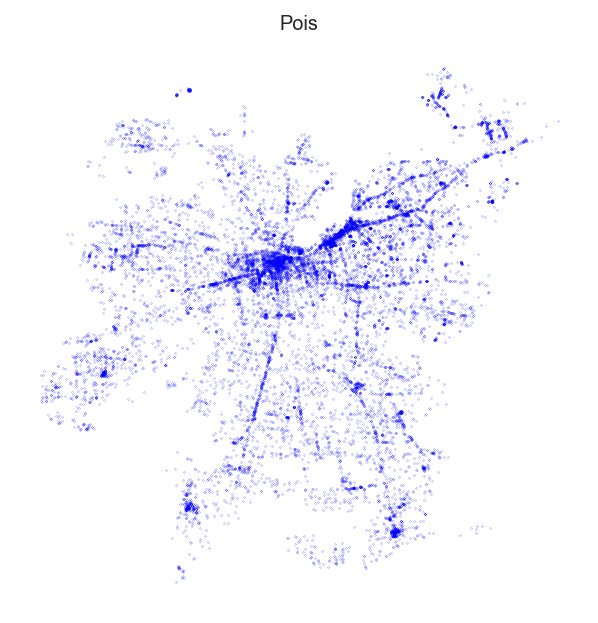

In [16]:
pois.plot(markersize=0.01, edgecolor='blue',figsize=(5, 5));
plt.axis('off');
plt.title("Pois");

In [17]:
pois_school = pois[pois.fclass == 'school']
pois_restaurant = pois[pois.fclass == 'restaurant']

---

### Getting Roads

In [18]:
roads_path = "../data/OSM_Chile/chile-latest-free/gis_osm_roads_free_1.shp"
roads = gpd.read_file(roads_path, encoding='utf-8', crs={'init': 'epsg:5361'})
roads.shape

(454572, 11)

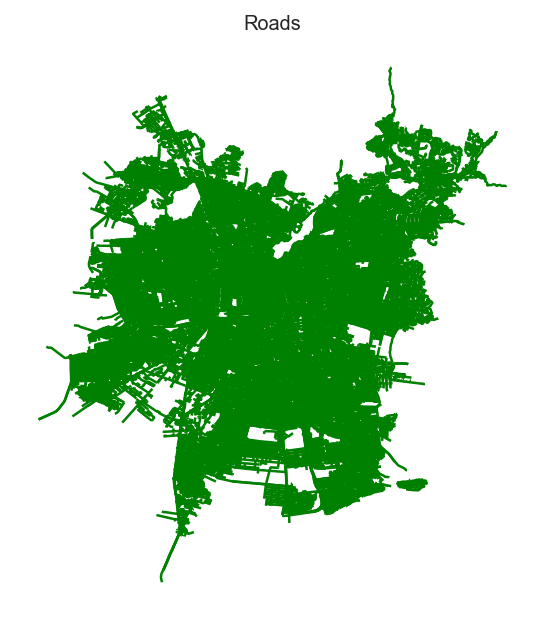

In [19]:
roads = gpd.sjoin(roads, stgo_shape, op='intersects')
roads.plot(markersize=0.01, edgecolor='green',figsize=(5, 5));
plt.axis('off');
plt.title("Roads");

In [20]:
del roads['index_right']
del roads['NOMBRE']
del roads['TIPO_AREA']
del roads['SHAPE_Leng']
del roads['SHAPE_Area']

In [21]:
roads.crs = {'init' :'epsg:4326'}

In [22]:
roads.head(2)

osm_id  code        fclass           name   ref oneway  maxspeed  layer  \
0  7981156  5121  unclassified     21 de Mayo  None      B         0      0   
1  7981159  5114     secondary  Irene Morales  None      F         0      0   

  bridge tunnel                                           geometry  
0      F      F  LINESTRING (-70.6502258 -33.4348941, -70.65025...  
1      F      F  LINESTRING (-70.6369668 -33.4368647, -70.63678...

In [23]:
roads.oneway.value_counts()

B    68109
F    14723
T       27
Name: oneway, dtype: int64

In [24]:
roads.maxspeed.value_counts()

0      79036
60      1138
50       748
40       510
30       505
100      326
20       220
80       213
120      107
70        18
10        15
35        12
15         8
140        1
8          1
5          1
Name: maxspeed, dtype: int64

In [25]:
roads.bridge.value_counts()

F    81945
T      914
Name: bridge, dtype: int64

In [26]:
roads.tunnel.value_counts()

F    82498
T      361
Name: tunnel, dtype: int64

In [27]:
roads.layer.value_counts()

 0    81442
 1      795
-1      367
 2      106
 3       55
 4       38
 5       37
-2       15
-3        4
Name: layer, dtype: int64

In [29]:
roads.fclass.value_counts()

residential       31592
living_street     14810
service           12188
footway           10222
tertiary           3516
secondary          3004
primary            2985
motorway            833
primary_link        773
motorway_link       694
pedestrian          540
steps               358
unclassified        350
secondary_link      324
cycleway            248
tertiary_link       165
path                157
track                93
track_grade2          4
bridleway             1
track_grade1          1
track_grade3          1
Name: fclass, dtype: int64

In [58]:
service = roads[roads.fclass == 'service']

In [59]:
m = folium.Map(location=[-33.4535395845603, -70.65641338735799], tiles="cartodbpositron", zoom_start=16)
m.choropleth(geo_data=service, fill_color = 'r', fill_opacity=0)
m

In [36]:
footway = roads[roads.fclass == 'footway']

In [60]:
roads_car = roads[(roads.fclass != 'service') & (roads.fclass != 'footway')]

---

### Getting Traffic Points

In [45]:
path = "../data/OSM_Chile/chile-latest-free/gis_osm_traffic_free_1.shp"
traffic = gpd.read_file(path, encoding='utf-8', crs={'init': 'epsg:5361'})
traffic.shape

(34359, 5)

In [46]:
traffic.head()

osm_id  code           fclass  name                                geometry
0  386138  5201  traffic_signals  None   POINT (-70.64619190000001 -33.442939)
1  386140  5201  traffic_signals  None  POINT (-70.64770059999999 -33.4431066)
2  386145  5201  traffic_signals  None         POINT (-70.6489631 -33.4433862)
3  386147  5201  traffic_signals  None         POINT (-70.6504017 -33.4437201)
4  386157  5201  traffic_signals  None         POINT (-70.6584289 -33.4369574)

In [47]:
traffic.fclass.value_counts()

crossing               16222
traffic_signals         8426
stop                    2290
turning_circle          1683
parking                 1582
fuel                    1216
motorway_junction        951
street_lamp              753
parking_bicycle          412
mini_roundabout          265
waterfall                235
slipway                   82
marina                    58
weir                      58
parking_underground       57
service                   21
ford                      15
dam                       14
lock_gate                  9
parking_multistorey        8
speed_camera               2
Name: fclass, dtype: int64

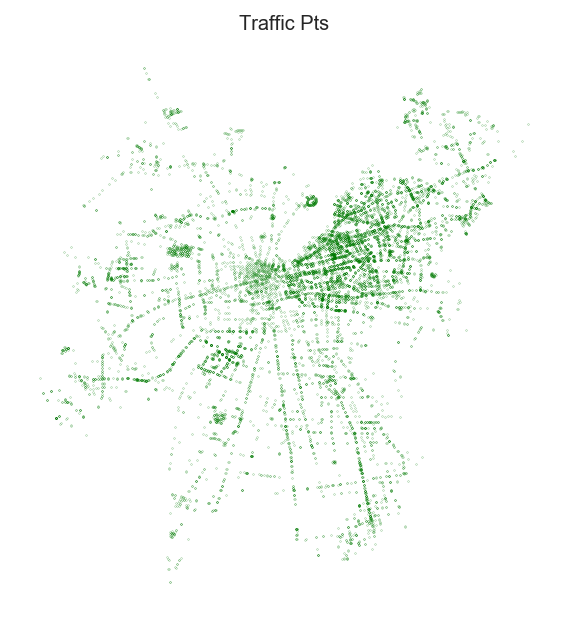

In [48]:
traffic = gpd.sjoin(traffic, stgo_shape, op='intersects')
traffic.plot(markersize=0.01, edgecolor='green',figsize=(5, 5));
plt.axis('off');
plt.title("Traffic Pts");

---

### Getting Transportation Points

In [49]:
path = "../data/OSM_Chile/chile-latest-free/gis_osm_transport_free_1.shp"
transp = gpd.read_file(path, encoding='utf-8', crs={'init': 'epsg:5361'})
transp.shape

(18600, 5)

In [50]:
transp.head()

osm_id  code           fclass                       name  \
0  122162580  5661   ferry_terminal    Terminal Ferry Dalcahue   
1  122380077  5661   ferry_terminal                       None   
2  141096340  5601  railway_station                     Toesca   
3  157416151  5621         bus_stop  Parada Colón-San Bernardo   
4  180172866  5661   ferry_terminal             Caleta Puelche   

                                 geometry  
0         POINT (-73.6554939 -42.3820313)  
1         POINT (-72.9455021 -43.8508824)  
2  POINT (-70.65851790000001 -33.4531263)  
3  POINT (-70.71533049999999 -33.5899825)  
4  POINT (-72.64747800000001 -41.7387864)

In [51]:
transp.fclass.value_counts()

bus_stop           17432
railway_station      428
bus_station          315
taxi                 227
ferry_terminal       160
railway_halt          32
tram_stop              6
Name: fclass, dtype: int64

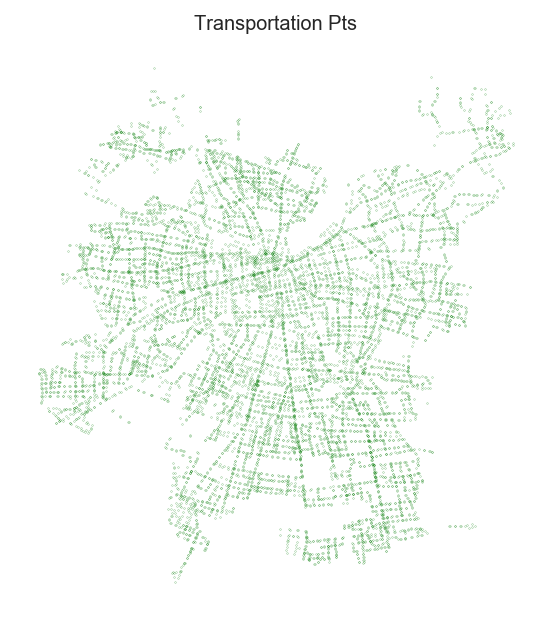

In [52]:
transp = gpd.sjoin(transp, stgo_shape, op='intersects')
transp.plot(markersize=0.01, edgecolor='green',figsize=(5, 5));
plt.axis('off');
plt.title("Transportation Pts");

---

### Getting Roads Intersections

In [77]:
roads.total_bounds

array([-70.8252846, -33.6882983, -70.4504647, -33.2762761])

In [78]:
G = ox.graph_from_bbox(-33.2762761, -33.6882983, -70.4504647, -70.8252846, network_type='drive') # N, S, E, W

In [79]:
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

1499284265.3061724

**Clean up the intersections**:
We'll specify that any nodes with 12 meters of each other in this network are part of the same intersection. We'll also specify that we do not want dead-ends returned in our list of cleaned intersections. Then we extract their xy coordinates.

In [80]:
intersections = ox.clean_intersections(G_proj, tolerance=12, dead_ends=False)

In [81]:
gdf = gpd.GeoDataFrame(geometry=intersections)
gdf.crs = G_proj.graph['crs']
intersect = ox.project_gdf(gdf, to_latlong=True)

In [82]:
intersect.to_file("../data/OSM_Chile/stgo_intersections/intersections.shp")

In [15]:
intersects = gpd.read_file("../data/OSM_Chile/stgo_intersections/intersections.shp")
intersects.shape

(81379, 2)

In [16]:
intersects.head()

FID                                geometry
0    0  POINT (-70.7234545 -33.68818310000001)
1    1         POINT (-70.7450927 -33.6874893)
2    2  POINT (-70.7262793 -33.68829830000001)
3    3  POINT (-70.7450711 -33.68788390000003)
4    4  POINT (-70.7451082 -33.68717910000002)

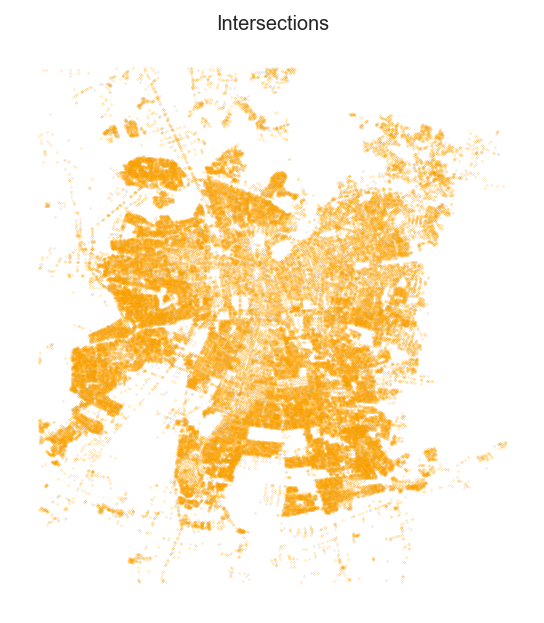

In [33]:
intersects.plot(markersize=0.01, edgecolor='orange',figsize=(5, 5));
plt.title("Intersections");
plt.axis('off');

### Visualizing a sample of Intersections (Santiago County)

In [17]:
esquinas_stgo = gpd.sjoin(intersects, com_stgo, op='intersects')

In [35]:
esquinas_stgo.head()

FID                                       geometry  index_right  \
44984  44984                 POINT (-70.6481991 -33.476502)          305   
44999  44999  POINT (-70.66786430000001 -33.47578080000002)          305   
45012  45012   POINT (-70.66481750000698 -33.4757457000057)          305   
45029  45029  POINT (-70.64201475000117 -33.47630135000031)          305   
45070  45070         POINT (-70.6464426 -33.47646010000001)          305   

                                NOM_REG  NOM_PROV   NOM_COM    SHAPE_LENG  \
44984  Región Metropolitana de Santiago  Santiago  Santiago  24644.018619   
44999  Región Metropolitana de Santiago  Santiago  Santiago  24644.018619   
45012  Región Metropolitana de Santiago  Santiago  Santiago  24644.018619   
45029  Región Metropolitana de Santiago  Santiago  Santiago  24644.018619   
45070  Región Metropolitana de Santiago  Santiago  Santiago  24644.018619   

       DIS_ELEC  CIR_SENA  COD_COMUNA    SHAPE_Le_1    SHAPE_Area  
44984        22         7        1310  22142.660056  2.276999e+07  
44999        22         7        1310  22142.660056  2.276999e+07  
45012        22         7        1310  22142.660056  2.276999e+07  
45029        22         7        1310  22142.660056  2.276999e+07  
45070        22         7        1310  22142.660056  2.276999e+07

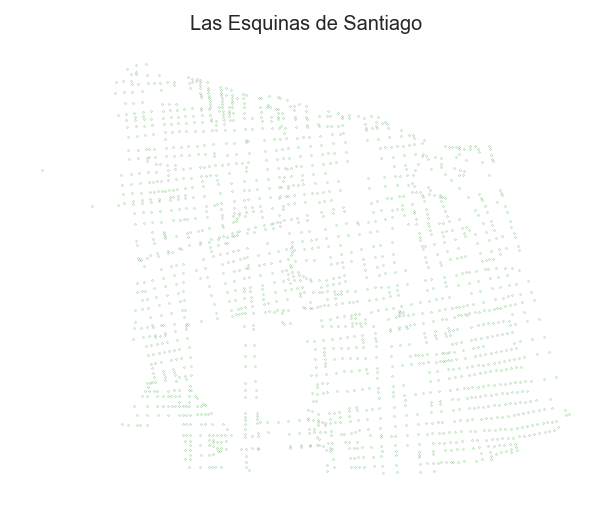

In [36]:
esquinas_stgo.plot(markersize=0.01, edgecolor='green',figsize=(5, 5));
plt.axis('off');
plt.title("Las Esquinas de Santiago");

In [37]:
com_stgo.centroid

305    POINT (-70.65641338735799 -33.4535395845603)
dtype: object

---

## Creating a grid 

https://github.com/mthh/gpd_lite_toolbox

In [20]:
def haver_dist_in_km(lat1, lat2, long1, long2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    long1, lat1, long2, lat2 = map(radians, [long1, lat1, long2, lat2])

    # haversine formula
    dlong = long2 - long1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlong/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    dist = round(c*r)
    return dist

In [21]:
# Limites aproximados provincia Santiago (RM)
y_lim = (-33.7,-33.1) # lat 
x_lim = (-70.9, -70.4) # long

In [22]:
# Calculate distance in kilometers equivalent to 0.1 degrees
haver_dist_in_km(-33.5, -33.6, -70.5, -70.5)

11

- 0.1 degree is aprox. 11 Km
- 50 m ==> ~0.00045 degrees

In [23]:
def mts_dgs(meters):
    return ((meters*0.1)/11000)

In [24]:
meters = 50

In [45]:
grid_height = mts_dgs(meters)

### Grid related with Intersections 

In [74]:
intersects = gpd.read_file("../data/OSM_Chile/stgo_intersections/intersections.shp")
intersects.shape

(81379, 2)

In [26]:
intersects.head()

FID                                geometry
0    0  POINT (-70.7234545 -33.68818310000001)
1    1         POINT (-70.7450927 -33.6874893)
2    2  POINT (-70.7262793 -33.68829830000001)
3    3  POINT (-70.7450711 -33.68788390000003)
4    4  POINT (-70.7451082 -33.68717910000002)

In [102]:
grid_stgo = glt.gridify_data(intersects, grid_height,'FID', method=np.sum)  

In [103]:
grid_stgo.shape

(690722, 2)

In [104]:
grid_stgo.head()

geometry    FID
0  POLYGON ((-70.82473980455853 -33.3300365502320...     -1
1  POLYGON ((-70.82476397177366 -33.3304238005239...  78903
2  POLYGON ((-70.82478327086007 -33.3308783459785...     -1
3  POLYGON ((-70.82478467114096 -33.3313328914330...     -1
4  POLYGON ((-70.82478607142185 -33.3317874368876...     -1

Let's plot the grid on Santiago County (Comuna) ONLY FOR SIMPLE VISUALIZATION:

In [65]:
grid_com_stgo = gpd.sjoin(grid_stgo, com_stgo, op='intersects')

In [67]:
grid_com_stgo.crs = {'init' :'epsg:4326'}

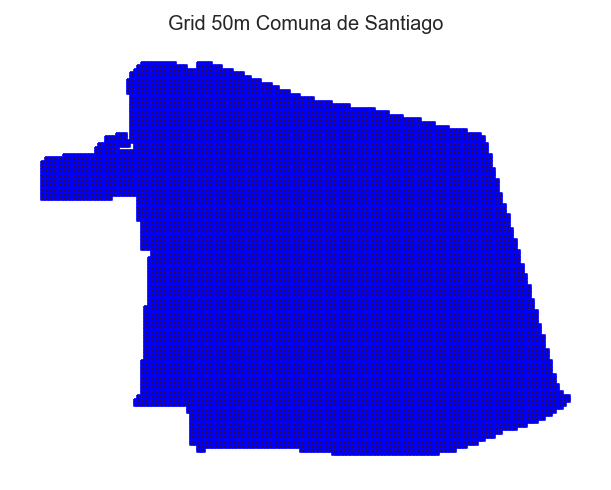

In [125]:
grid_com_stgo.plot(markersize=0.01, edgecolor='blue',figsize=(5, 5));
plt.axis('off');
plt.title("Grid 50m Comuna de Santiago");

In [ ]:
# m_plot_dataframe(grid, column='Total', contour_poly_width=0.5, colormap='Accent', edgecolor="grey")

In [134]:
grid_stgo.head()

geometry    FID
0  POLYGON ((-70.82473980455853 -33.3300365502320...     -1
1  POLYGON ((-70.82476397177366 -33.3304238005239...  78903
2  POLYGON ((-70.82478327086007 -33.3308783459785...     -1
3  POLYGON ((-70.82478467114096 -33.3313328914330...     -1
4  POLYGON ((-70.82478607142185 -33.3317874368876...     -1

In [136]:
stgo_grid_50m = gpd.GeoDataFrame(grid_stgo.geometry).reset_index()

In [137]:
stgo_grid_50m.columns = ['id', 'geometry']

In [138]:
stgo_grid_50m.head(2)

id                                           geometry
0   0  POLYGON ((-70.82473980455853 -33.3300365502320...
1   1  POLYGON ((-70.82476397177366 -33.3304238005239...

In [139]:
stgo_grid_50m.to_file("../data/OSM_Chile/grid/stgo_grid_50m.shp")

### Creating a generic grid creation function

In [44]:
def grid_meters(meters, gdf, col):
    grid_height = (meters*0.1)/11000
    grid = glt.gridify_data(gdf, grid_height,col, method=np.sum) 
    grid = grid.reset_index()
    del grid[col]  
    grid.crs = {'init' :'epsg:4326'}
    return grid

In [45]:
meters = 100
grid_100 = grid_meters(meters, intersects, 'FID')
grid_100.shape

(173047, 2)

In [46]:
grid_100.head(2)

index                                           geometry
0      0  POLYGON ((-70.82428525910399 -33.3227530109826...
1      1  POLYGON ((-70.82433846798388 -33.3236056187057...

In [48]:
grid_100.to_file("../data/OSM_Chile/grid/stgo_grid_100m.shp")

### Testing generic Grid

In [49]:
grid_100_com_stgo = gpd.sjoin(grid_100, com_stgo, op='intersects')
grid_100_com_stgo.crs = {'init' :'epsg:4326'}

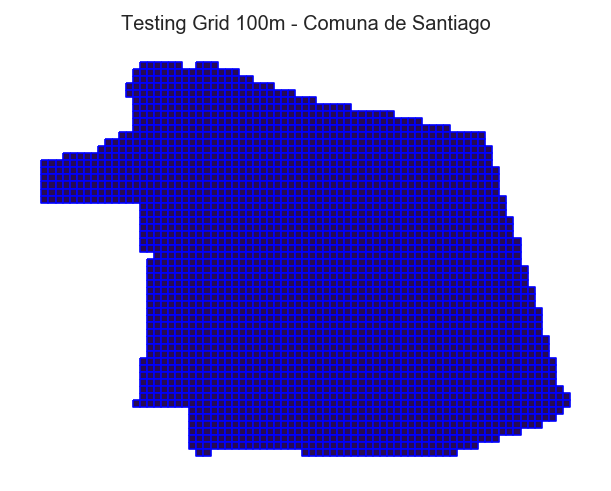

In [51]:
grid_100_com_stgo.plot(markersize=0.01, edgecolor='blue',figsize=(5, 5));
plt.axis('off');
plt.title("Testing Grid 100m - Comuna de Santiago");

In [53]:
esquinas_stgo = gpd.sjoin(intersects, com_stgo, op='intersects')
esquinas_stgo.crs = {'init' :'epsg:4326'}

---

### Grid related to Roads (Calles Discretizadas 'CD')

In [62]:
roads_car.head(2)

osm_id  code        fclass           name   ref oneway  maxspeed  layer  \
0  7981156  5121  unclassified     21 de Mayo  None      B         0      0   
1  7981159  5114     secondary  Irene Morales  None      F         0      0   

  bridge tunnel                                           geometry  
0      F      F  LINESTRING (-70.6502258 -33.4348941, -70.65025...  
1      F      F  LINESTRING (-70.6369668 -33.4368647, -70.63678...

In [54]:
grid_path = "../data/OSM_Chile/grid/stgo_grid_100m.shp"
grid = gpd.read_file(grid_path, encoding='utf-8', crs={'init': 'epsg:5361'})
grid.shape

(173047, 2)

In [63]:
grid_stgo_r = gpd.sjoin(grid, roads_car, op='intersects') 
grid_stgo_r.shape

(216504, 13)

In [64]:
grid_stgo_r.head(2)

index                                           geometry  index_right  \
258    258  POLYGON ((-70.8251902322438 -33.55724198234194...          663   
614    614  POLYGON ((-70.82428525910399 -33.5572419823419...          663   

       osm_id  code    fclass               name ref oneway  maxspeed  layer  \
258  22700558  5111  motorway  Autopista del Sol  78      F       120      0   
614  22700558  5111  motorway  Autopista del Sol  78      F       120      0   

    bridge tunnel  
258      F      F  
614      F      F

In [65]:
grid_stgo_r = grid_stgo_r.groupby('index',
                                  as_index=False).agg({'geometry': 'first'})
grid_stgo_r.shape

(63029, 2)

In [66]:
grid_stgo_r.head()

index                                           geometry
0    258  POLYGON ((-70.8251902322438 -33.55724198234194...
1    613  POLYGON ((-70.82428525910399 -33.5563328914328...
2    614  POLYGON ((-70.82428525910399 -33.5572419823419...
3    987  POLYGON ((-70.8233761681949 -33.55633289143285...
4    988  POLYGON ((-70.8233761681949 -33.55724198234194...

In [67]:
del grid_stgo_r['index']

In [68]:
grid_stgo_r.head(2)

geometry
0  POLYGON ((-70.8251902322438 -33.55724198234194...
1  POLYGON ((-70.82428525910399 -33.5563328914328...

In [69]:
stgo_grid_to_roads_100m = gpd.GeoDataFrame(grid_stgo_r.geometry)

In [70]:
stgo_grid_to_roads_100m.crs = {'init' :'epsg:4326'}

In [71]:
stgo_grid_to_roads_100m.to_file("../data/OSM_Chile/grid/stgo_grid_to_roads_100m.shp")

### Creating a 50 meters Grid to Roads

In [216]:
grid_path = "../data/OSM_Chile/grid/stgo_grid_50m.shp"
grid = gpd.read_file(grid_path, encoding='utf-8', crs={'init': 'epsg:5361'})
grid.shape

(690722, 2)

In [217]:
grid_stgo_r = gpd.sjoin(grid, roads, op='intersects') 
grid_stgo_r.shape

(459094, 13)

In [218]:
grid_stgo_r.head(2)

id                                           geometry  index_right  \
501    501  POLYGON ((-70.82519053420036 -33.5576965277964...          659   
1178  1178  POLYGON ((-70.82473980455853 -33.5572419823419...          659   

        osm_id  code    fclass               name ref oneway  maxspeed  layer  \
501   22700387  5111  motorway  Autopista del Sol  78      F       120      0   
1178  22700387  5111  motorway  Autopista del Sol  78      F       120      0   

     bridge tunnel  
501       F      F  
1178      F      F

In [219]:
grid_stgo_r = grid_stgo_r.groupby('id',
                as_index=False).agg({'geometry': 'first'})
grid_stgo_r.shape

(219088, 2)

In [220]:
grid_stgo_r.head()

id                                           geometry
0   501  POLYGON ((-70.82519053420036 -33.5576965277964...
1  1178  POLYGON ((-70.82473980455853 -33.5572419823419...
2  1179  POLYGON ((-70.82473980455853 -33.5576965277964...
3  1873  POLYGON ((-70.82428525910399 -33.5572419823419...
4  2585  POLYGON ((-70.82383071364944 -33.5567874368874...

In [221]:
del grid_stgo_r['id']

In [222]:
grid_stgo_r.head(2)

geometry
0  POLYGON ((-70.82519053420036 -33.5576965277964...
1  POLYGON ((-70.82473980455853 -33.5572419823419...

In [223]:
stgo_grid_to_roads_50m = gpd.GeoDataFrame(grid_stgo_r.geometry)

In [224]:
stgo_grid_to_roads_50m.crs = {'init' :'epsg:4326'}

In [225]:
stgo_grid_to_roads_50m.to_file(
    "../data/OSM_Chile/grid/stgo_grid_to_roads_50m.shp")

### Testing Grid 100 to roads 

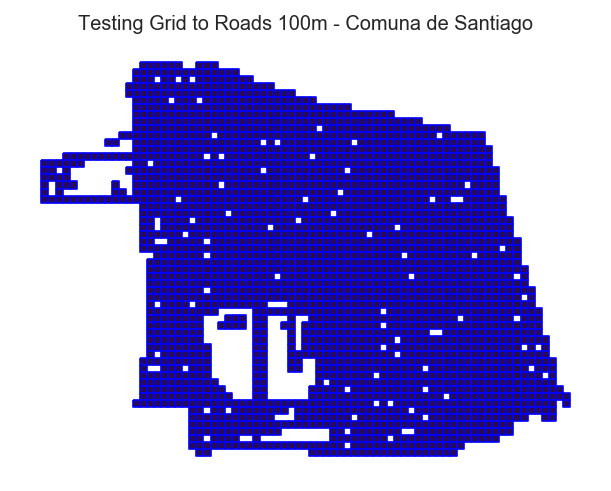

In [72]:
com_stgo_grid_to_roads_100m = gpd.sjoin(stgo_grid_to_roads_100m, com_stgo, op='intersects')
com_stgo_grid_to_roads_100m.crs = {'init' :'epsg:4326'}

com_stgo_grid_to_roads_100m.plot(markersize=0.01, edgecolor='blue',figsize=(5, 5));
plt.axis('off');
plt.title("Testing Grid to Roads 100m - Comuna de Santiago");

### Testing Grid 50 to roads 

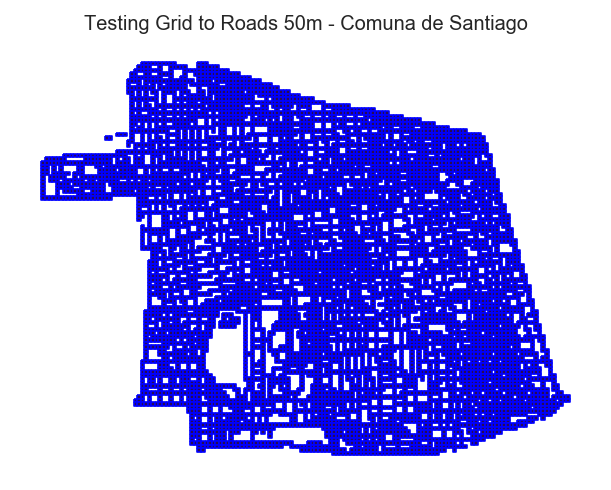

In [226]:
com_stgo_grid_to_roads_50m = gpd.sjoin(stgo_grid_to_roads_50m, com_stgo, op='intersects')
com_stgo_grid_to_roads_50m.crs = {'init' :'epsg:4326'}

com_stgo_grid_to_roads_50m.plot(markersize=0.01, edgecolor='blue',figsize=(5, 5));
plt.axis('off');
plt.title("Testing Grid to Roads 50m - Comuna de Santiago");

---

## Adding Static features to road grid ('CD')

In [82]:
grid_path = "../data/OSM_Chile/grid/stgo_grid_to_roads_100m.shp"
grid = gpd.read_file(grid_path, encoding='utf-8', crs={'init': 'epsg:4326'})
grid.shape

(63029, 2)

In [83]:
grid.head()

FID                                           geometry
0    0  POLYGON ((-70.8251902322438 -33.55724198234194...
1    1  POLYGON ((-70.82428525910399 -33.5563328914328...
2    2  POLYGON ((-70.82428525910399 -33.5572419823419...
3    3  POLYGON ((-70.8233761681949 -33.55633289143285...
4    4  POLYGON ((-70.8233761681949 -33.55724198234194...

In [84]:
grid.columns 

Index(['FID', 'geometry'], dtype='object')

### Including Intersections on Grid

In [85]:
intersects = gpd.read_file("../data/OSM_Chile/stgo_intersections/intersections.shp")
intersects.shape

(81379, 2)

In [86]:
gi = gpd.sjoin(grid, intersects, how='left', op='intersects')

In [87]:
gi.head()

FID_left                                           geometry  index_right  \
0         0  POLYGON ((-70.8251902322438 -33.55724198234194...          NaN   
1         1  POLYGON ((-70.82428525910399 -33.5563328914328...          NaN   
2         2  POLYGON ((-70.82428525910399 -33.5572419823419...      17891.0   
3         3  POLYGON ((-70.8233761681949 -33.55633289143285...          NaN   
4         4  POLYGON ((-70.8233761681949 -33.55724198234194...          NaN   

   FID_right  
0        NaN  
1        NaN  
2    17891.0  
3        NaN  
4        NaN

In [88]:
gi = gi.fillna(0)

In [89]:
gi = gi.rename(columns={'index_right':'intercect'})

In [90]:
del gi['FID_right']

In [91]:
gi.head()

FID_left                                           geometry  intercect
0         0  POLYGON ((-70.8251902322438 -33.55724198234194...        0.0
1         1  POLYGON ((-70.82428525910399 -33.5563328914328...        0.0
2         2  POLYGON ((-70.82428525910399 -33.5572419823419...    17891.0
3         3  POLYGON ((-70.8233761681949 -33.55633289143285...        0.0
4         4  POLYGON ((-70.8233761681949 -33.55724198234194...        0.0

In [92]:
gi['intercect'] = gi['intercect'].apply(lambda x: 0 if x== 0 else 1)

In [93]:
gi.intercect.value_counts()

1    73200
0    23232
Name: intercect, dtype: int64

In [94]:
gi = gi.groupby('FID_left', as_index=False).agg({
  'intercect': 'sum', 
  'geometry': 'first',
  })

In [95]:
gi = gpd.GeoDataFrame(gi, crs='4326')

In [96]:
gi.shape

(63029, 3)

In [97]:
gi.sample(10)

FID_left  intercect                                           geometry
21524     21524          1  POLYGON ((-70.67973980455866 -33.5226965277965...
22287     22287          2  POLYGON ((-70.67701253183139 -33.5036056187056...
51533     51533          2  POLYGON ((-70.56337616819513 -33.5436056187055...
30936     30936          3  POLYGON ((-70.64337616819506 -33.5390601641601...
16130     16130          1  POLYGON ((-70.70064889546774 -33.4790601641602...
60491     60491          0  POLYGON ((-70.51883071364972 -33.396332891433,...
3159       3159          1  POLYGON ((-70.76428525910404 -33.4408783459784...
969         969          2  POLYGON ((-70.78337616819493 -33.5426965277965...
4416       4416          2  POLYGON ((-70.75610344092223 -33.3608783459784...
11154     11154          0  POLYGON ((-70.72064889546772 -33.3445147096148...

In [98]:
gi.intercect.value_counts()

0    23232
1    17979
2    13482
3     5835
4     1908
5      466
6      103
7       20
8        4
Name: intercect, dtype: int64

### Join POI & Grid

In [99]:
def adding_pois(g, pois, fclass):
    pois_x = pois[pois.fclass == fclass]
    x = pois_x[['geometry']].copy()
    g = gpd.sjoin(g, x, how='left', op='intersects')
    g = g.fillna(0)
    g = g.rename(columns={'index_right': fclass})
    g[fclass] = g[fclass].apply(lambda x: 0 if x == 0.0 else 1)
    g = g.groupby('FID', as_index=False).agg({
        fclass: 'sum',
        'geometry': 'first',
    })
    g = gpd.GeoDataFrame(g, crs='5361')
    print("grid shape: ", g.shape)
    print("Static Feature type {} has {} events".format(
        fclass, g[fclass].sum()))
    return g

In [100]:
pois.fclass.value_counts()

restaurant         1778
school             1652
convenience        1043
kindergarten        919
bench               769
pharmacy            735
fast_food           726
playground          593
beverages           566
cafe                547
bank                486
bakery              411
hairdresser         358
clothes             314
butcher             215
doityourself        194
supermarket         190
waste_basket        176
dentist             169
bicycle_rental      163
kiosk               156
beauty_shop         150
atm                 133
bicycle_shop        132
bar                 127
veterinary          126
car_dealership      118
laundry             115
hotel               113
post_office         112
                   ... 
tower                15
travel_agent         15
swimming_pool        14
outdoor_shop         12
pitch                11
arts_centre          10
recycling_paper       9
chalet                8
prison                8
garden_centre         7
newsagent       

In [101]:
fclass = 'restaurant'
rest = adding_pois(grid, pois, fclass)

grid shape:  (63029, 3)
Static Feature type restaurant has 1709 events


In [102]:
fclass = 'school'
school = adding_pois(grid, pois, fclass)

grid shape:  (63029, 3)
Static Feature type school has 1578 events


In [103]:
fclass = 'convenience'
convenience = adding_pois(grid, pois, fclass)

grid shape:  (63029, 3)
Static Feature type convenience has 1036 events


In [104]:
fclass = 'kindergarten'
kindergarten = adding_pois(grid, pois, fclass)

grid shape:  (63029, 3)
Static Feature type kindergarten has 905 events


In [105]:
fclass = 'bench'
bench = adding_pois(grid, pois, fclass)

grid shape:  (63029, 3)
Static Feature type bench has 719 events


In [106]:
fclass = 'pharmacy'
pharmacy = adding_pois(grid, pois, fclass)

grid shape:  (63029, 3)
Static Feature type pharmacy has 714 events


In [107]:
fclass = 'fast_food'
fast_food = adding_pois(grid, pois, fclass)

grid shape:  (63029, 3)
Static Feature type fast_food has 668 events


In [108]:
fclass = 'beverages'
beverages = adding_pois(grid, pois, fclass)

grid shape:  (63029, 3)
Static Feature type beverages has 565 events


In [109]:
fclass = 'cafe'
cafe = adding_pois(grid, pois, fclass)

grid shape:  (63029, 3)
Static Feature type cafe has 524 events


In [110]:
fclass = 'bank'
bank = adding_pois(grid, pois, fclass)

grid shape:  (63029, 3)
Static Feature type bank has 467 events


### Join Traffic Points to Grid

In [111]:
traffic.fclass.value_counts()

crossing               5894
traffic_signals        4032
stop                    563
parking                 433
parking_bicycle         266
motorway_junction       175
fuel                    153
turning_circle          148
street_lamp              90
mini_roundabout          63
parking_underground      36
parking_multistorey       5
service                   1
Name: fclass, dtype: int64

In [112]:
fclass = 'crossing'
crossing = adding_pois(grid, traffic, fclass)

grid shape:  (63029, 3)
Static Feature type crossing has 5860 events


In [113]:
fclass = 'traffic_signals'
traffic_signals = adding_pois(grid, traffic, fclass)

grid shape:  (63029, 3)
Static Feature type traffic_signals has 4029 events


In [114]:
fclass = 'stop'
stop = adding_pois(grid, traffic, fclass)

grid shape:  (63029, 3)
Static Feature type stop has 563 events


In [115]:
fclass = 'parking'
parking = adding_pois(grid, traffic, fclass)

grid shape:  (63029, 3)
Static Feature type parking has 391 events


In [116]:
fclass = 'parking_bicycle'
parking_bicycle = adding_pois(grid, traffic, fclass)

grid shape:  (63029, 3)
Static Feature type parking_bicycle has 249 events


In [117]:
fclass = 'motorway_junction'
motorway_junction = adding_pois(grid, traffic, fclass)

grid shape:  (63029, 3)
Static Feature type motorway_junction has 175 events


In [118]:
fclass = 'fuel'
fuel = adding_pois(grid, traffic, fclass)

grid shape:  (63029, 3)
Static Feature type fuel has 150 events


In [119]:
fclass = 'turning_circle'
turning_circle = adding_pois(grid, traffic, fclass)

grid shape:  (63029, 3)
Static Feature type turning_circle has 144 events


### Join Transportation Points to Grid

In [120]:
transp.fclass.value_counts()

bus_stop           10349
railway_station      135
taxi                  41
bus_station           10
Name: fclass, dtype: int64

In [121]:
fclass = 'bus_stop'
bus_stop = adding_pois(grid, transp, fclass)

grid shape:  (63029, 3)
Static Feature type bus_stop has 10318 events


In [122]:
fclass = 'railway_station'
railway_station = adding_pois(grid, transp, fclass)

grid shape:  (63029, 3)
Static Feature type railway_station has 134 events


In [123]:
fclass = 'taxi'
taxi = adding_pois(grid, transp, fclass)

grid shape:  (63029, 3)
Static Feature type taxi has 40 events


## Adding new Static Features on a distance (meters)

In [124]:
grid_path = "../data/OSM_Chile/grid/stgo_grid_to_roads_100m.shp"
grid = gpd.read_file(grid_path, encoding='utf-8', crs={'init': 'epsg:4326'})
grid.shape

(63029, 2)

In [125]:
g = grid
osm_shp = pois
fclass = 'school'
meters = 100

In [126]:
pois_x = osm_shp[osm_shp.fclass == fclass]
x = pois_x[['geometry']].copy()

In [127]:
dist = (meters*0.1)/11000

In [128]:
x.head()

geometry
320          POINT (-70.6993394 -33.5966745)
698   POINT (-70.62878379999999 -33.4440206)
717          POINT (-70.5045116 -33.3928932)
1441         POINT (-70.6376276 -33.6128439)
1442         POINT (-70.6354175 -33.6152206)

In [129]:
x['geometry']= x.geometry.buffer(dist)

In [130]:
x.head()

geometry
320   POLYGON ((-70.69843030909091 -33.5966745, -70....
698   POLYGON ((-70.6278747090909 -33.4440206, -70.6...
717   POLYGON ((-70.50360250909091 -33.3928932, -70....
1441  POLYGON ((-70.63671850909091 -33.6128439, -70....
1442  POLYGON ((-70.63450840909091 -33.6152206, -70....

In [131]:
x = gpd.sjoin(g, x, how='left', op='intersects')
x = x.fillna(0)
x.head()

FID                                           geometry  index_right
0    0  POLYGON ((-70.8251902322438 -33.55724198234194...          0.0
1    1  POLYGON ((-70.82428525910399 -33.5563328914328...          0.0
2    2  POLYGON ((-70.82428525910399 -33.5572419823419...          0.0
3    3  POLYGON ((-70.8233761681949 -33.55633289143285...          0.0
4    4  POLYGON ((-70.8233761681949 -33.55724198234194...          0.0

In [132]:
fclass = fclass+'_'+str(meters)
x = x.rename(columns={'index_right': fclass})

In [133]:
x.head()

FID                                           geometry  school_100
0    0  POLYGON ((-70.8251902322438 -33.55724198234194...         0.0
1    1  POLYGON ((-70.82428525910399 -33.5563328914328...         0.0
2    2  POLYGON ((-70.82428525910399 -33.5572419823419...         0.0
3    3  POLYGON ((-70.8233761681949 -33.55633289143285...         0.0
4    4  POLYGON ((-70.8233761681949 -33.55724198234194...         0.0

In [134]:
x[fclass] = x[fclass].apply(lambda x: 0 if x == 0.0 else 1)
x = x.groupby('FID', as_index=False).agg({
    fclass: 'sum',
    'geometry': 'first',
})
x = gpd.GeoDataFrame(x, crs='4326')
print("grid shape: ", x.shape)
print("Static Feature type {} has {} events".format(
    fclass, x[fclass].sum()))

grid shape:  (63029, 3)
Static Feature type school_100 has 12675 events


### Creating a Function

In [135]:
def adding_static_feat_dist_to_grid(g,
                                    osm_shp,
                                    feature,
                                    meters,
                                    agg_type='sum'):
    pois_x = osm_shp[osm_shp.fclass == feature]
    x = pois_x[['geometry']].copy()
    dist = (meters * 0.1) / 11000
    x['geometry'] = x.geometry.buffer(dist)
    x = gpd.sjoin(g, x, how='left', op='intersects')
    x = x.fillna(0)
    feature = feature + '_' + str(meters)
    x = x.rename(columns={'index_right': feature})
    x[feature] = x[feature].apply(lambda x: 0 if x == 0.0 else 1)
    x = x.groupby('FID', as_index=False).agg({
        feature: agg_type,
        'geometry': 'first',
    })
    x = gpd.GeoDataFrame(x, crs='4326')
    print("grid shape: ", x.shape)
    print("Static Feature type {} has {} events".format(
        feature, x[feature].sum()))
    return x

In [136]:
g = grid
osm_shp = pois
meters = 100

In [137]:
feature = 'school'
school_100 = adding_static_feat_dist_to_grid(g, osm_shp, feature, meters)

grid shape:  (63029, 3)
Static Feature type school_100 has 12675 events


In [138]:
pois.fclass.value_counts()

restaurant         1778
school             1652
convenience        1043
kindergarten        919
bench               769
pharmacy            735
fast_food           726
playground          593
beverages           566
cafe                547
bank                486
bakery              411
hairdresser         358
clothes             314
butcher             215
doityourself        194
supermarket         190
waste_basket        176
dentist             169
bicycle_rental      163
kiosk               156
beauty_shop         150
atm                 133
bicycle_shop        132
bar                 127
veterinary          126
car_dealership      118
laundry             115
hotel               113
post_office         112
                   ... 
tower                15
travel_agent         15
swimming_pool        14
outdoor_shop         12
pitch                11
arts_centre          10
recycling_paper       9
chalet                8
prison                8
garden_centre         7
newsagent       

In [139]:
school_200 = adding_static_feat_dist_to_grid(grid, pois, 'school', 200)

grid shape:  (63029, 3)
Static Feature type school_200 has 33261 events


In [140]:
restaurant_100 = adding_static_feat_dist_to_grid(grid, pois, 'restaurant', 100)

grid shape:  (63029, 3)
Static Feature type restaurant_100 has 13815 events


In [141]:
restaurant_200 = adding_static_feat_dist_to_grid(grid, pois, 'restaurant', 200)

grid shape:  (63029, 3)
Static Feature type restaurant_200 has 36307 events


In [142]:
convenience_100 = adding_static_feat_dist_to_grid(grid, pois, 'convenience', 100)

grid shape:  (63029, 3)
Static Feature type convenience_100 has 8203 events


In [143]:
convenience_200 = adding_static_feat_dist_to_grid(grid, pois, 'convenience', 200)

grid shape:  (63029, 3)
Static Feature type convenience_200 has 21584 events


In [144]:
fast_food_100 = adding_static_feat_dist_to_grid(grid, pois, 'fast_food', 100)

grid shape:  (63029, 3)
Static Feature type fast_food_100 has 5404 events


In [145]:
fast_food_200 = adding_static_feat_dist_to_grid(grid, pois, 'fast_food', 200)

grid shape:  (63029, 3)
Static Feature type fast_food_200 has 14425 events


In [146]:
traffic.fclass.value_counts()

crossing               5894
traffic_signals        4032
stop                    563
parking                 433
parking_bicycle         266
motorway_junction       175
fuel                    153
turning_circle          148
street_lamp              90
mini_roundabout          63
parking_underground      36
parking_multistorey       5
service                   1
Name: fclass, dtype: int64

In [147]:
crossing_100 = adding_static_feat_dist_to_grid(grid, traffic, 'crossing', 100)

grid shape:  (63029, 3)
Static Feature type crossing_100 has 45344 events


In [148]:
traffic_signals_100 = adding_static_feat_dist_to_grid(grid, traffic, 'traffic_signals', 100)

grid shape:  (63029, 3)
Static Feature type traffic_signals_100 has 30939 events


In [149]:
stop_100 = adding_static_feat_dist_to_grid(grid, traffic, 'stop', 100)

grid shape:  (63029, 3)
Static Feature type stop_100 has 4431 events


In [150]:
transp.fclass.value_counts()

bus_stop           10349
railway_station      135
taxi                  41
bus_station           10
Name: fclass, dtype: int64

In [151]:
bus_stop_100 = adding_static_feat_dist_to_grid(grid, transp, 'bus_stop', 100)

grid shape:  (63029, 3)
Static Feature type bus_stop_100 has 79473 events


In [152]:
railway_station_100 = adding_static_feat_dist_to_grid(grid, transp, 'railway_station', 100)

grid shape:  (63029, 3)
Static Feature type railway_station_100 has 1028 events


## Creating a Static Features dataset

In [153]:
def concat_dataset(df1, df2):
    data = pd.concat([df1, df2], axis = 1)
    _, i = np.unique(data.columns, return_index=True)
    data = data.iloc[:, i]
    return data

In [154]:
data = grid.copy()

In [155]:
data["X"] = data.centroid.x
data["Y"] = data.centroid.y
data.head(2)

FID                                           geometry          X  \
0    0  POLYGON ((-70.8251902322438 -33.55724198234194... -70.824738   
1    1  POLYGON ((-70.82428525910399 -33.5563328914328... -70.823831   

           Y  
0 -33.557697  
1 -33.556787

In [156]:
data = concat_dataset(data, gi)

In [157]:
data.intercect.sum()

73200

In [158]:
data = concat_dataset(data, rest)
data = concat_dataset(data, restaurant_100)
data = concat_dataset(data, restaurant_100)

In [159]:
data = concat_dataset(data, school)
data = concat_dataset(data, school_100)
data = concat_dataset(data, school_200)

In [160]:
data = concat_dataset(data, convenience)
data = concat_dataset(data, convenience_100)
data = concat_dataset(data, convenience_200)

In [161]:
data = concat_dataset(data, kindergarten)
data = concat_dataset(data, bench)
data = concat_dataset(data, pharmacy)

In [162]:
data = concat_dataset(data, fast_food)
data = concat_dataset(data, fast_food_100)
data = concat_dataset(data, fast_food_200)

In [163]:
data = concat_dataset(data, beverages)
data = concat_dataset(data, cafe)
data = concat_dataset(data, bank)

In [164]:
data = concat_dataset(data, crossing)
data = concat_dataset(data, crossing_100)
data = concat_dataset(data, traffic_signals)
data = concat_dataset(data, traffic_signals_100)
data = concat_dataset(data, stop)
data = concat_dataset(data, stop_100)

In [165]:
data = concat_dataset(data, parking)
data = concat_dataset(data, parking_bicycle)
data = concat_dataset(data, motorway_junction)
data = concat_dataset(data, fuel)
data = concat_dataset(data, turning_circle)

In [166]:
data = concat_dataset(data, bus_stop)
data = concat_dataset(data, bus_stop_100)
data = concat_dataset(data, railway_station)
data = concat_dataset(data, railway_station_100)
data = concat_dataset(data, taxi)

In [167]:
data.head()

FID  FID_left          X          Y  bank  bench  beverages  bus_stop  \
0    0         0 -70.824738 -33.557697     0      0          0         0   
1    1         1 -70.823831 -33.556787     0      0          0         0   
2    2         2 -70.823831 -33.557697     0      0          0         0   
3    3         3 -70.822922 -33.556787     0      0          0         0   
4    4         4 -70.822922 -33.557697     0      0          0         0   

   bus_stop_100  cafe  ...  restaurant_100  school  school_100  school_200  \
0             0     0  ...               0       0           0           0   
1             0     0  ...               0       0           0           0   
2             0     0  ...               0       0           0           0   
3             0     0  ...               0       0           0           0   
4             0     0  ...               0       0           0           0   

   stop  stop_100  taxi  traffic_signals  traffic_signals_100 turning_circle  
0     0         0     0                0                    0              0  
1     0         0     0                0                    0              0  
2     0         0     0                0                    0              0  
3     0         0     0                0                    0              0  
4     0         0     0                0                    0              0  

[5 rows x 39 columns]

In [168]:
del data['FID']
del data['FID_left']

In [169]:
data.shape

(63029, 37)

In [170]:
data.head(2)

X          Y  bank  bench  beverages  bus_stop  bus_stop_100  cafe  \
0 -70.824738 -33.557697     0      0          0         0             0     0   
1 -70.823831 -33.556787     0      0          0         0             0     0   

   convenience  convenience_100  ...  restaurant_100  school  school_100  \
0            0                0  ...               0       0           0   
1            0                0  ...               0       0           0   

   school_200  stop  stop_100  taxi traffic_signals  traffic_signals_100  \
0           0     0         0     0               0                    0   
1           0     0         0     0               0                    0   

   turning_circle  
0               0  
1               0  

[2 rows x 37 columns]

In [171]:
data.crs = {'init' :'epsg:4326'}
data.to_file("../data/OSM_Chile/grid/geo_stgo_100_estatic_dataset.shp")

### Creating a .CSV Static Feature dataset

In [172]:
dt = data.copy()

In [173]:
del dt['geometry']
dt.head(2)

X          Y  bank  bench  beverages  bus_stop  bus_stop_100  cafe  \
0 -70.824738 -33.557697     0      0          0         0             0     0   
1 -70.823831 -33.556787     0      0          0         0             0     0   

   convenience  convenience_100  ...  restaurant_100  school  school_100  \
0            0                0  ...               0       0           0   
1            0                0  ...               0       0           0   

   school_200  stop  stop_100  taxi  traffic_signals  traffic_signals_100  \
0           0     0         0     0                0                    0   
1           0     0         0     0                0                    0   

   turning_circle  
0               0  
1               0  

[2 rows x 36 columns]

In [174]:
dt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 63029 entries, 0 to 63028
Data columns (total 36 columns):
X                      63029 non-null float64
Y                      63029 non-null float64
bank                   63029 non-null int64
bench                  63029 non-null int64
beverages              63029 non-null int64
bus_stop               63029 non-null int64
bus_stop_100           63029 non-null int64
cafe                   63029 non-null int64
convenience            63029 non-null int64
convenience_100        63029 non-null int64
convenience_200        63029 non-null int64
crossing               63029 non-null int64
crossing_100           63029 non-null int64
fast_food              63029 non-null int64
fast_food_100          63029 non-null int64
fast_food_200          63029 non-null int64
fuel                   63029 non-null int64
intercect              63029 non-null int64
kindergarten           63029 non-null int64
motorway_junction      63029 non-null int64

In [175]:
dt.sample(5)

X          Y  bank  bench  beverages  bus_stop  bus_stop_100  \
59428 -70.525649 -33.391333     0      0          0         0             0   
12426 -70.714740 -33.506787     0      0          0         0             3   
49938 -70.568376 -33.386787     0      0          0         0             0   
49658 -70.570194 -33.598606     0      0          0         0             0   
26012 -70.662922 -33.448606     0      0          0         0             0   

       cafe  convenience  convenience_100  ...  restaurant_100  school  \
59428     0            0                0  ...               0       0   
12426     0            0                0  ...               0       0   
49938     0            0                0  ...               0       0   
49658     0            0                0  ...               0       0   
26012     0            0                1  ...               3       0   

       school_100  school_200  stop  stop_100  taxi  traffic_signals  \
59428           0           0     0         0     0                0   
12426           0           0     0         0     0                0   
49938           0           0     0         1     0                0   
49658           0           0     0         0     0                0   
26012           0           3     0         0     0                0   

       traffic_signals_100  turning_circle  
59428                    1               0  
12426                    2               0  
49938                    0               0  
49658                    0               0  
26012                    0               0  

[5 rows x 36 columns]

In [176]:
dt.to_csv("../data/geo_stgo_100_estatic_dataset.csv")

---